In [82]:
import pandas as pd
import numpy as np
import json
import os
import statistics

import matplotlib.pyplot as plt
import seaborn as sns

In [129]:
def tally_votes(votes_dict):
    """
    Tally yes/no/abstain counts from a votes dictionary.
    
    Args:
        votes_dict (dict): keys are vote IDs, values are dicts with at least a 'vote' key.
        
    Returns:
        dict: counts of 'yes', 'no', and 'abstain'
    """
    counts = {"yes": 0, "no": 0, "abstain": 0}

    for item in votes_dict.values():
        vote = item.get('vote', '').strip().lower()
        if vote == 'yes':
            counts['yes'] += 1
        elif vote == 'no':
            counts['no'] += 1
        else:
            counts['abstain'] += 1

    return counts

def compute_micro_profile(all_responses):
    """Compute micro-profile using complete responses (no sentence splitting)."""
    num_responses = len(all_responses)
    if num_responses == 0:
        return {}
    
    response_lengths = [len(r['text'].split()) for r in all_responses]
    avg_words_per_turn = sum(response_lengths) / num_responses
    longest_response_length = max(response_lengths) if response_lengths else 0
    shortest_response_length = min(response_lengths) if response_lengths else 0
    response_length_variance = statistics.variance(response_lengths) if len(response_lengths) > 1 else 0.0
    
    question_freq = sum('?' in r['text'] for r in all_responses) / num_responses
    
    hedges = ["maybe", "might", "could", "probably", "perhaps", "i think", "i guess"]
    hedging_count = sum(any(h in r['text'].lower() for h in hedges) for r in all_responses)
    hedging_rate = hedging_count / num_responses
    
    directives = ["please", "assign", "do", "create", "publish"]
    directive_count = sum(any(d in r['text'].lower() for d in directives) for r in all_responses)
    directive_rate = directive_count / num_responses
    
    polite_words = ["please", "thanks", "thank you", "sorry"]
    politeness_count = sum(any(p in r['text'].lower() for p in polite_words) for r in all_responses)
    politeness_rate = politeness_count / num_responses
    
    return {
        "avg_words_per_turn": avg_words_per_turn,
        "longest_response_length": longest_response_length,
        "shortest_response_length": shortest_response_length,
        "response_length_variance": response_length_variance,
        "question_freq": question_freq,
        "hedging_rate": hedging_rate,
        "directive_rate": directive_rate,
        "politeness_rate": politeness_rate
    }


def speaker_micro_profiles(conversation):
    """
    Compute micro-profiles per speaker.
    
    Args:
        conversation (list of dict): each dict has 'speaker' and 'content'
    
    Returns:
        dict: keys are speaker names, values are micro-profile dicts
    """
    from collections import defaultdict

    # Group all turns by speaker
    speaker_responses = defaultdict(list)
    for turn in conversation:
        speaker_responses[turn['speaker']].append({'text': turn['content']})

    # Compute micro-profile for each speaker
    profiles = {}
    for speaker, responses in speaker_responses.items():
        profiles[speaker] = compute_micro_profile(responses)
    
    return profiles

def plot_feature_comparison(gt_df, sim_df, feature_name, param_set=''):
    speakers = gt_df.columns
    x = np.arange(len(speakers))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12,6))
    ax.bar(x - width/2, gt_df.loc[feature_name], width, label='Ground Truth', color='skyblue')
    ax.bar(x + width/2, sim_df.loc[feature_name], width, label='Simulation', color='orange')

    ax.set_ylabel(feature_name)
    ax.set_title(f'Comparison of {feature_name} by Speaker')
    ax.set_xticks(x)
    ax.set_xticklabels(speakers, rotation=45)
    ax.legend()
    fig.suptitle(param_set)
    plt.tight_layout()
    plt.show()
    
def plot_scatter_comparison(gt_df, sim_df, agenda_item, param_set):
    features = gt_df.index
    features = ['avg_words_per_turn', 'longest_response_length',
       'question_freq', 'hedging_rate', 'directive_rate', 'politeness_rate']
    num_features = len(features)
    fig, axes = plt.subplots(nrows=int(np.ceil(num_features/3)), ncols=3, figsize=(15, num_features*2))
    axes = axes.flatten()

    for i, feature in enumerate(features):
        axes[i].scatter(gt_df.loc[feature], sim_df.loc[feature], color='purple')
        axes[i].plot([gt_df.loc[feature].min(), gt_df.loc[feature].max()],
                     [gt_df.loc[feature].min(), gt_df.loc[feature].max()], 'r--')
        axes[i].set_xlabel('Ground Truth')
        axes[i].set_ylabel('Simulation')
        axes[i].set_title(feature)
    fig.suptitle(f'Agenda Item {agenda_item}, Param Set {param_set}')
    plt.tight_layout()
    plt.savefig(f'figures/scatter_compare_{agenda_item}_{param_set}.png')

def plot_vote_comparison(public_dict, private_dict):
    """
    Compare public vs private approval rates for each agenda item and parameter set.
    
    Parameters
    ----------
    public_dict : dict
        Dictionary with keys (agenda_item, param_set) -> list of dicts with 'yes' and 'no'.
    private_dict : dict
        Same structure as public_dict, for private votes.
    """

    results = []

    # Collect results into a list
    for item in public_dict.keys():
        agenda_item, param_set = item
        public = public_dict[(agenda_item, param_set)]    
        private = private_dict[(agenda_item, param_set)]

        # Compute approval %
        private_df = pd.DataFrame(private)
        private_df['approve%'] = private_df['yes'] / (private_df['yes'] + private_df['no']) * 100

        public_df = pd.DataFrame(public)
        public_df['approve%'] = public_df['yes'] / (public_df['yes'] + public_df['no']) * 100

        pub_approve = public_df['approve%'].mean()
        private_approve = private_df['approve%'].mean()

        results.append([agenda_item, param_set, pub_approve, private_approve])

    # Put results in DataFrame
    results_df = pd.DataFrame(results, columns=["agenda_item", "param_set", "pub_approve", "private_approve"])

    # Make one plot per agenda item
    for agenda_item, group in results_df.groupby("agenda_item"):
        x = range(len(group))

        plt.figure(figsize=(8, 5))
        plt.bar([i - 0.2 for i in x], group["pub_approve"], width=0.4, label="Public")
        plt.bar([i + 0.2 for i in x], group["private_approve"], width=0.4, label="Private")

        plt.xticks(x, group["param_set"], rotation=45, ha="right")
        plt.ylabel("Approval %")
        plt.title(f"Agenda Item {agenda_item} - Vote Comparison")
        plt.legend()
        plt.tight_layout()
        plt.savefig(f'figures/vote_compare_{agenda_item}.png')


### Setup

In [ ]:
micro_profiles_path = '/playpen-ssd/smerrill/llm_decisions/configs/micro_profiles.json'

with open(micro_profiles_path, 'r') as f:
    micro_profiles = json.load(f)
    
sys_message = 'sys1'
agenda_item = 0
path = f'/playpen-ssd/smerrill/llm_decisions/results_simulation/{sys_message}/AgendaItem_{agenda_item}'
runs = os.listdir(path)
param_sets = os.listdir(f'{path}/Run1')

### Loading Data

In [117]:
messages_dict = {}
public_dict = {}
private_dict = {}

for agenda_item in [0, 1, 2, 3, 4]:
    path = f'/playpen-ssd/smerrill/llm_decisions/results_simulation/{sys_message}/AgendaItem_{agenda_item}'
    try:
        runs = os.listdir(path)
    except:
        continue
    param_sets = os.listdir(f'{path}/Run1')
    
    for param_set in param_sets:
        messages = []
        public = []
        private = []
        
        for run in runs:
            conversation_path = os.path.join(path, run, param_set, 'full_conversation.json')
            public_path = os.path.join(path, run, param_set, 'public_votes.json')
            private_path = os.path.join(path, run, param_set, 'private_votes.json')
            
            try:
                with open(conversation_path, 'r') as f:
                    data = json.load(f)
                messages.extend(data[1:-1])
            except:
                continue
            
            try:
                with open(public_path, 'r') as f:
                    data = json.load(f)
                public.append(tally_votes(data))
            except:
                continue

            try:
                with open(private_path, 'r') as f:
                    data = json.load(f)
                private.append(tally_votes(data))
            except:
                continue

        messages_dict[(agenda_item, param_set)] = messages
        public_dict[(agenda_item, param_set)] = public
        private_dict[(agenda_item, param_set)] = private

### 1. Scatter Compare

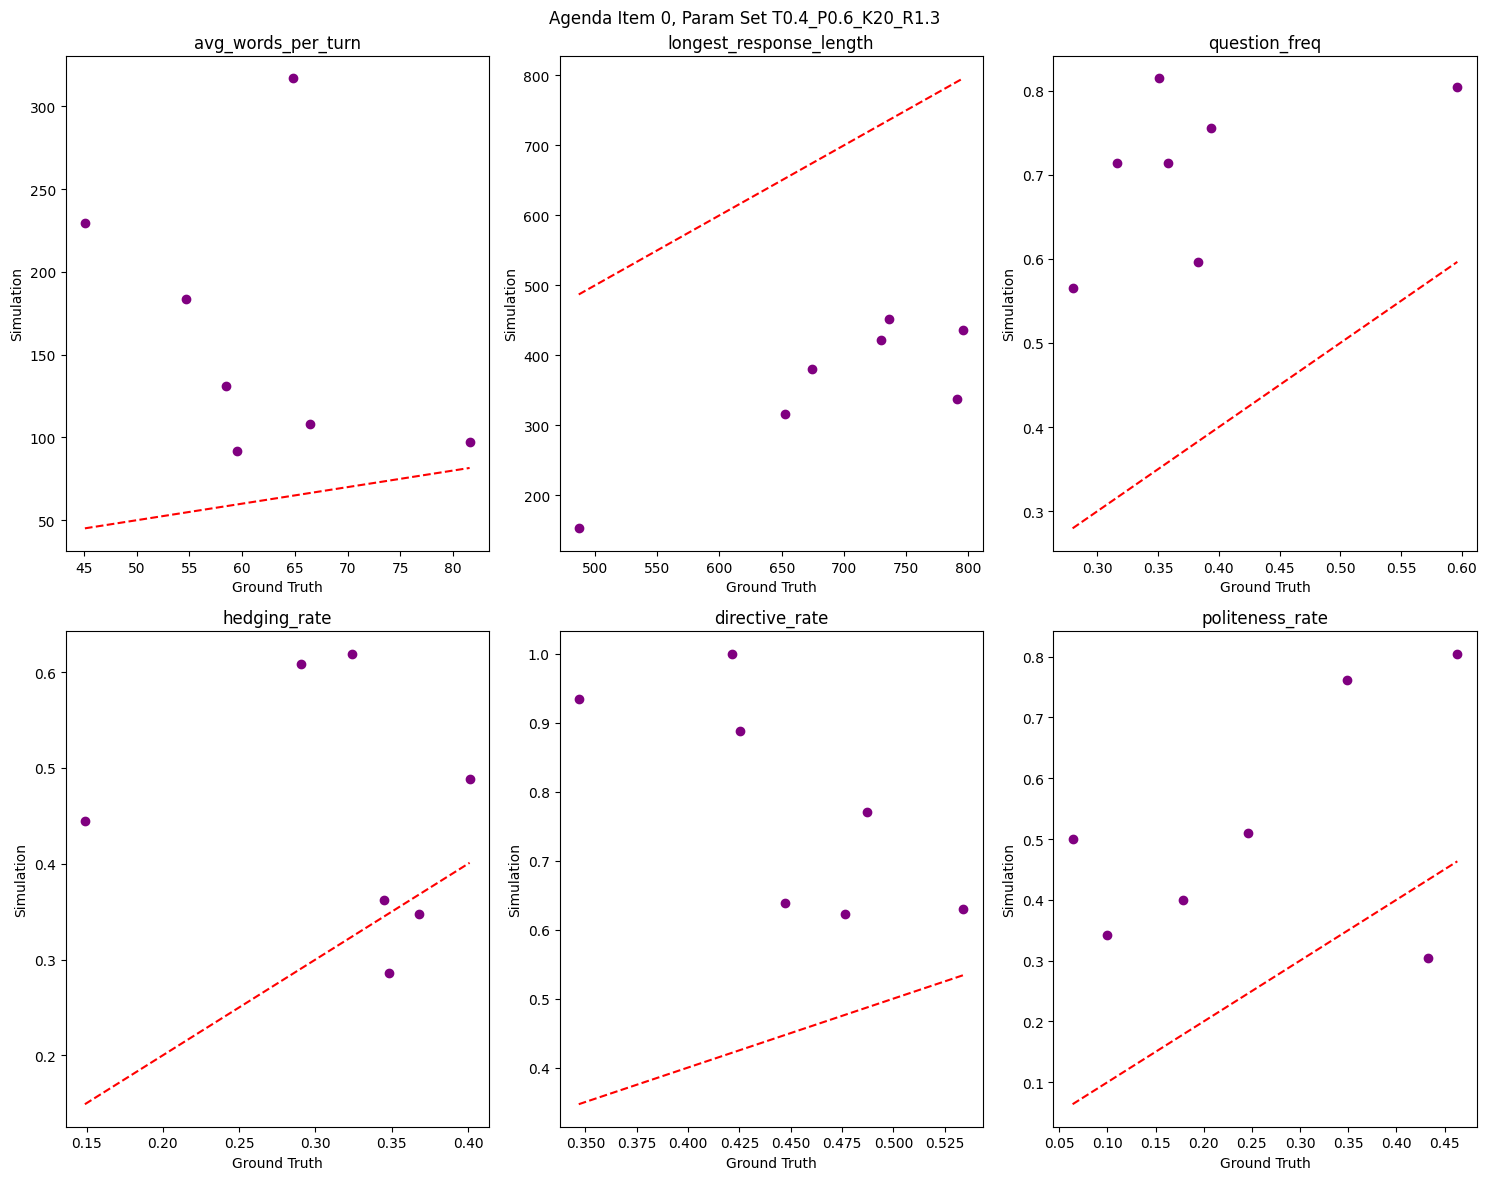

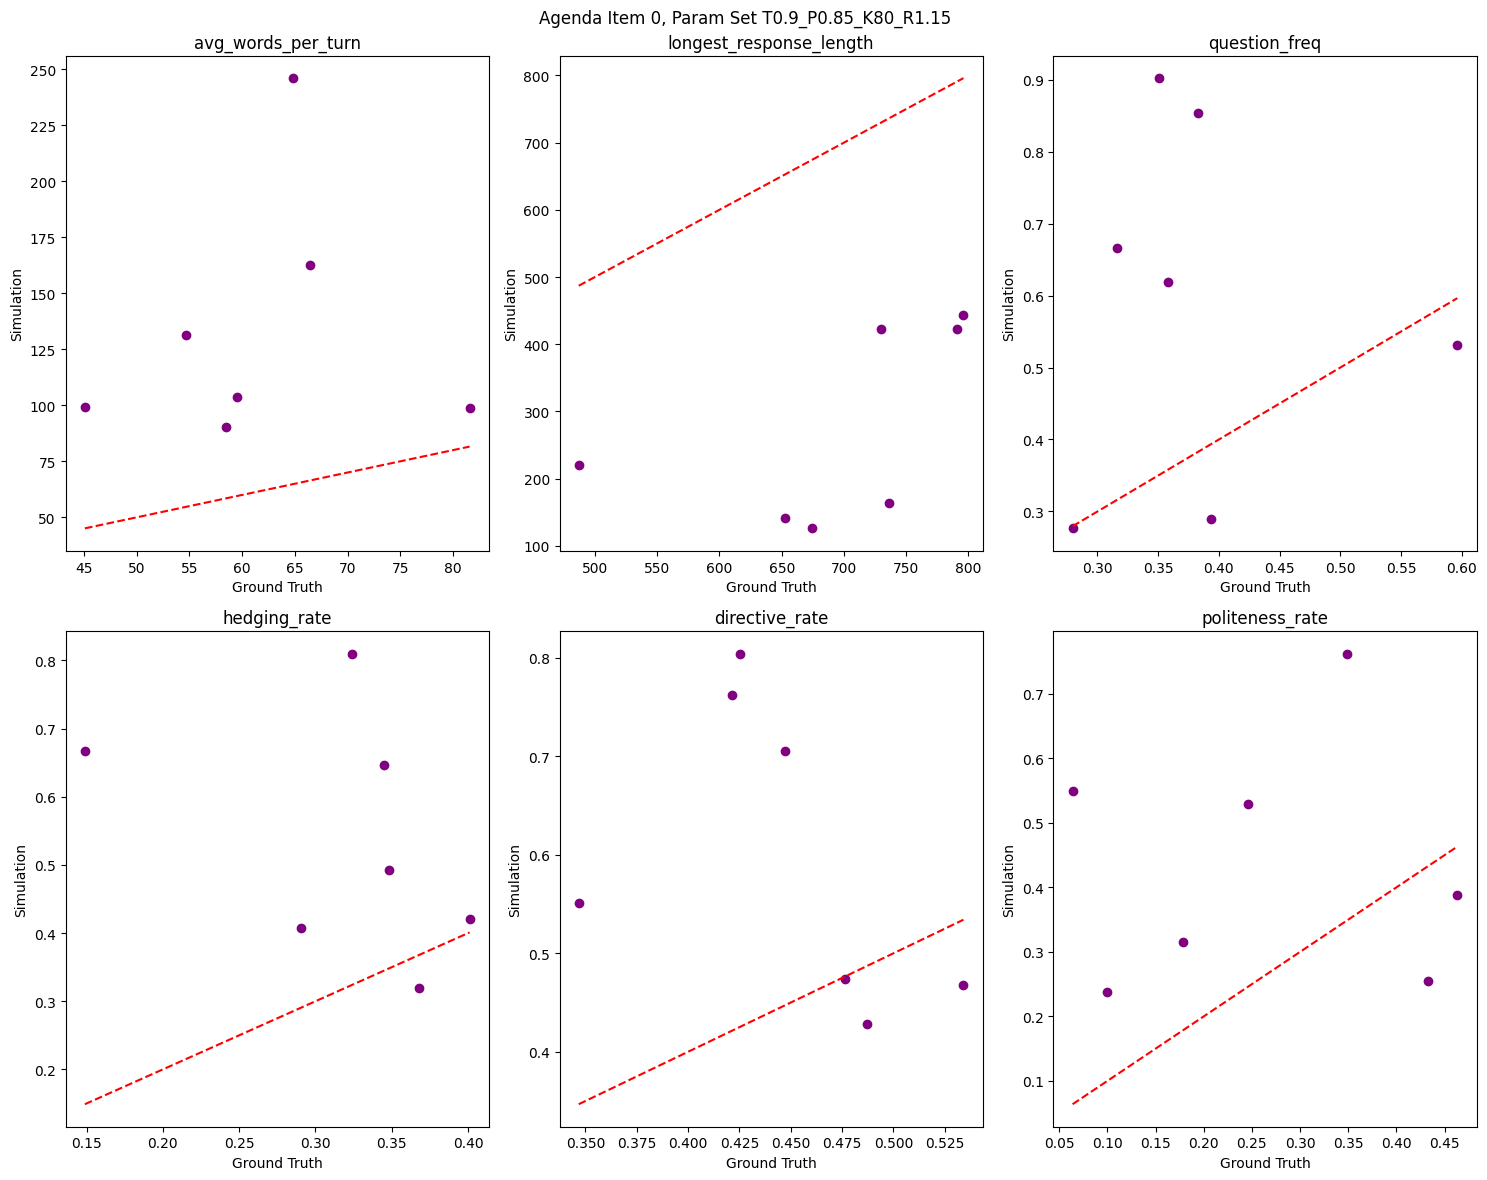

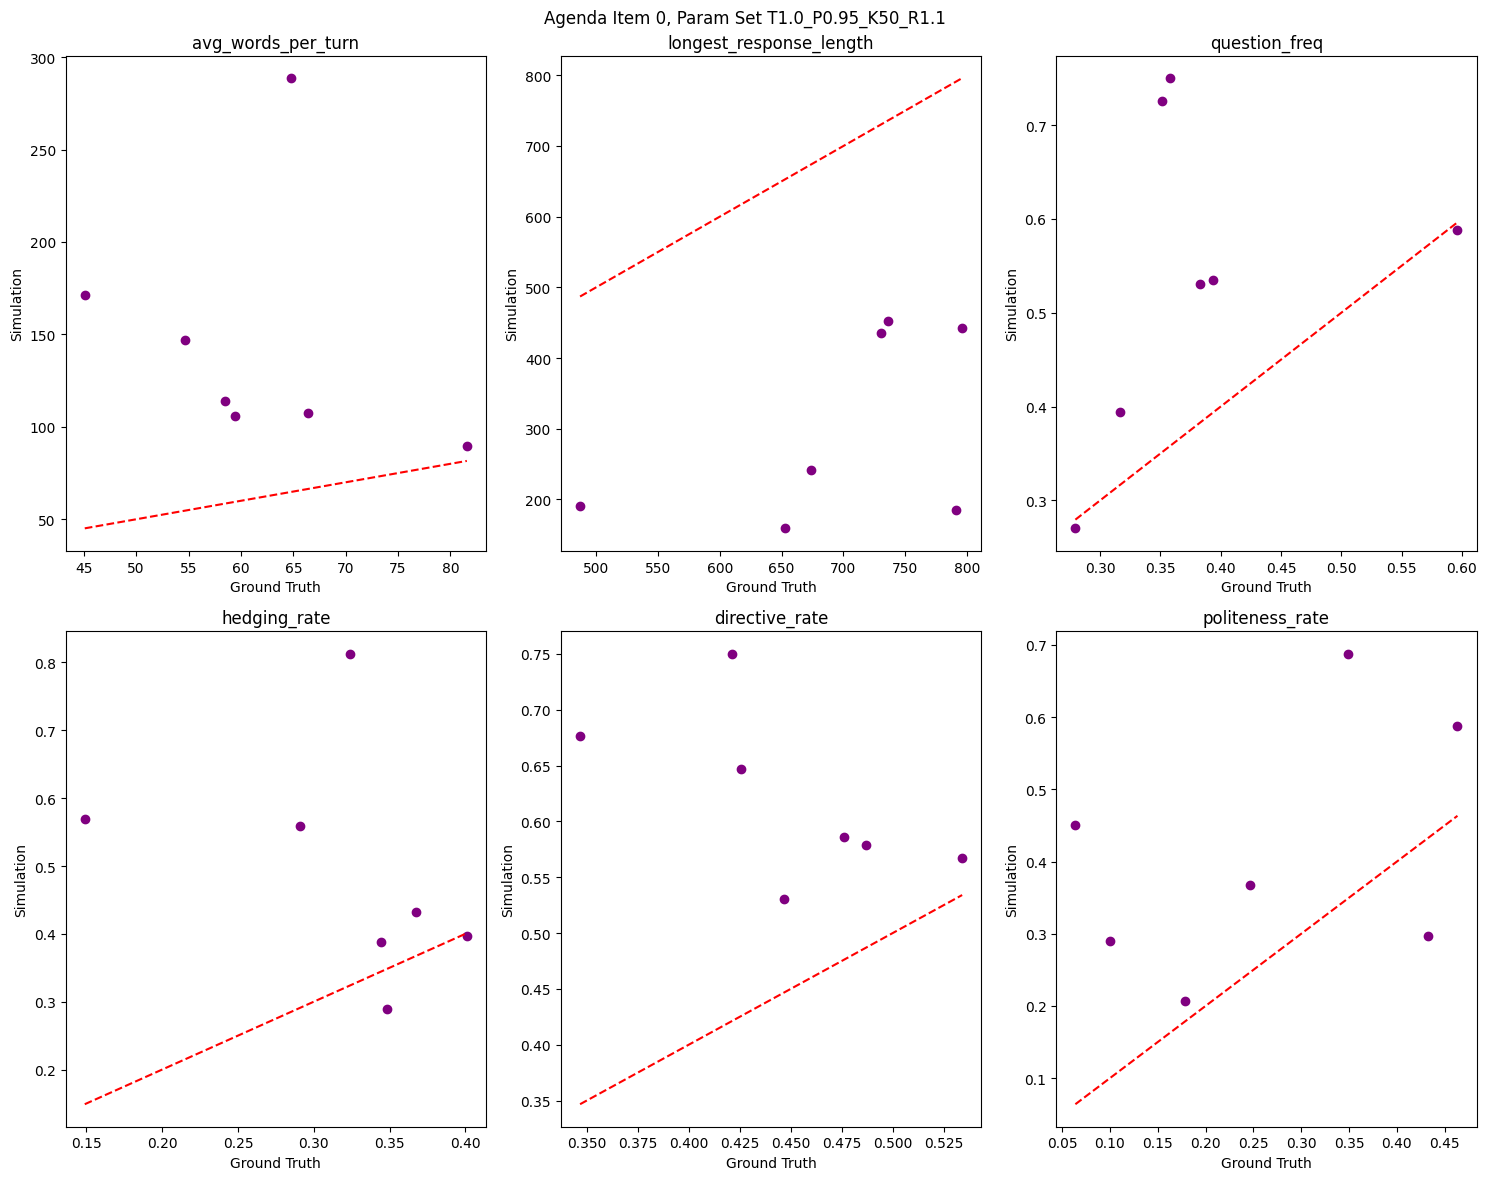

In [126]:
got_profiles = pd.DataFrame(micro_profiles)

for agenda_item in set(k[0] for k in messages_dict.keys()):
    # get all param sets for this agenda item
    param_sets = [k[1] for k in messages_dict.keys() if k[0] == agenda_item]

    if len(param_sets) == 1:
        axes = [axes]  # ensure iterable if only one subplot

    for ax, param_set in zip(axes, param_sets):
        messages = messages_dict[(agenda_item, param_set)]
        profiles = speaker_micro_profiles(messages)
        simulation_profiles = pd.DataFrame(profiles)

        plot_scatter_comparison(got_profiles, simulation_profiles, agenda_item, param_set)

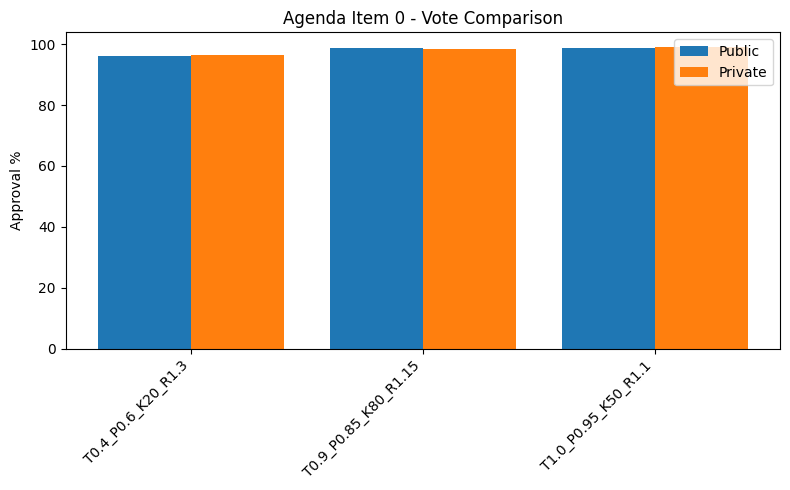

In [130]:
plot_vote_comparison(public_dict, private_dict)

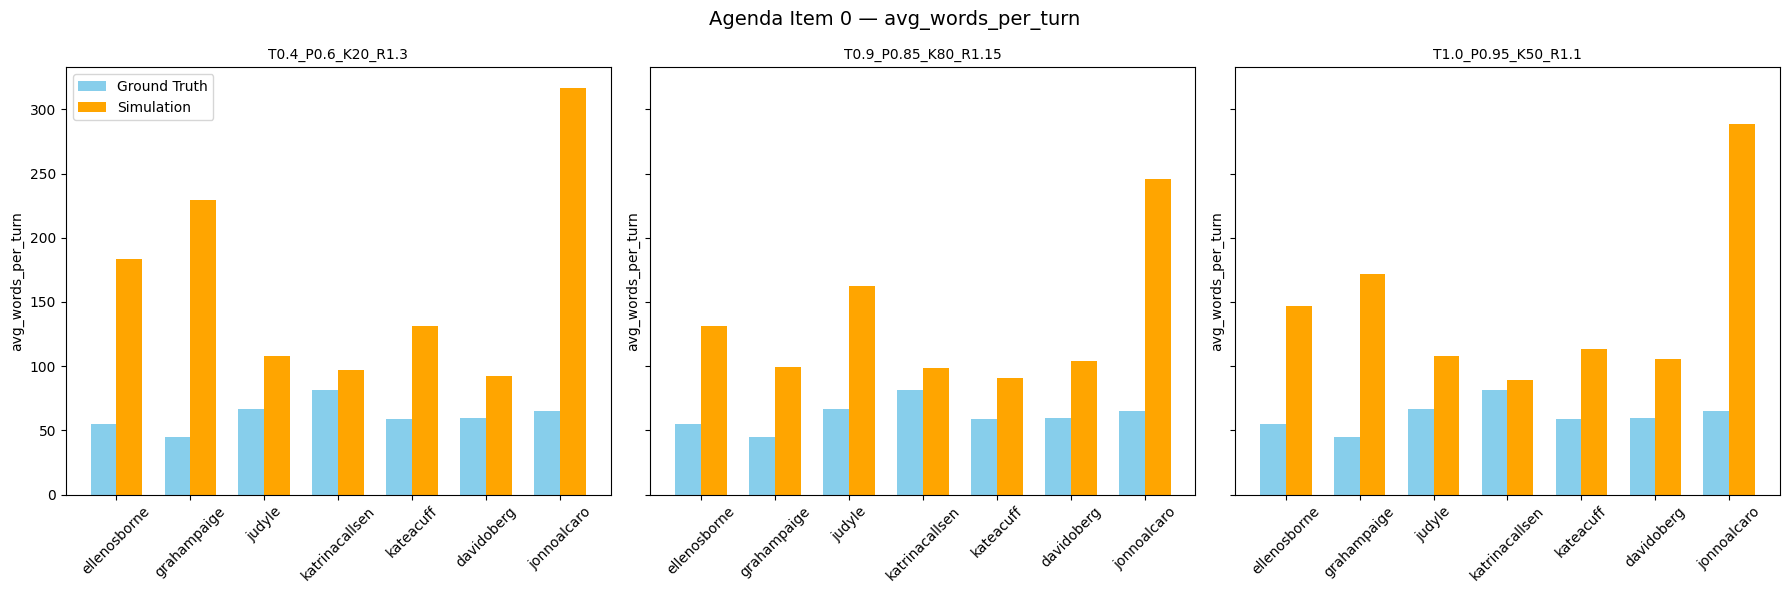

In [131]:
def plot_feature_comparison(gt_df, sim_df, feature_name, ax, param_set=''):
    speakers = gt_df.columns
    x = np.arange(len(speakers))
    width = 0.35

    ax.bar(x - width/2, gt_df.loc[feature_name], width, label='Ground Truth', color='skyblue')
    ax.bar(x + width/2, sim_df.loc[feature_name], width, label='Simulation', color='orange')

    ax.set_ylabel(feature_name)
    ax.set_title(param_set, fontsize=10)
    ax.set_xticks(x)
    ax.set_xticklabels(speakers, rotation=45)

# --- main plotting loop ---
got_profiles = pd.DataFrame(micro_profiles)
feature = "avg_words_per_turn"

for agenda_item in set(k[0] for k in messages_dict.keys()):
    # get all param sets for this agenda item
    param_sets = [k[1] for k in messages_dict.keys() if k[0] == agenda_item]

    fig, axes = plt.subplots(1, len(param_sets), figsize=(6 * len(param_sets), 6), sharey=True)
    if len(param_sets) == 1:
        axes = [axes]  # ensure iterable if only one subplot

    for ax, param_set in zip(axes, param_sets):
        messages = messages_dict[(agenda_item, param_set)]
        profiles = speaker_micro_profiles(messages)
        simulation_profiles = pd.DataFrame(profiles)

        plot_feature_comparison(got_profiles, simulation_profiles, feature, ax, param_set)

    fig.suptitle(f"Agenda Item {agenda_item} — {feature}", fontsize=14)
    axes[0].legend()
    plt.tight_layout()
    plt.savefig(f'figures/{agenda_item}_{feature}.png')


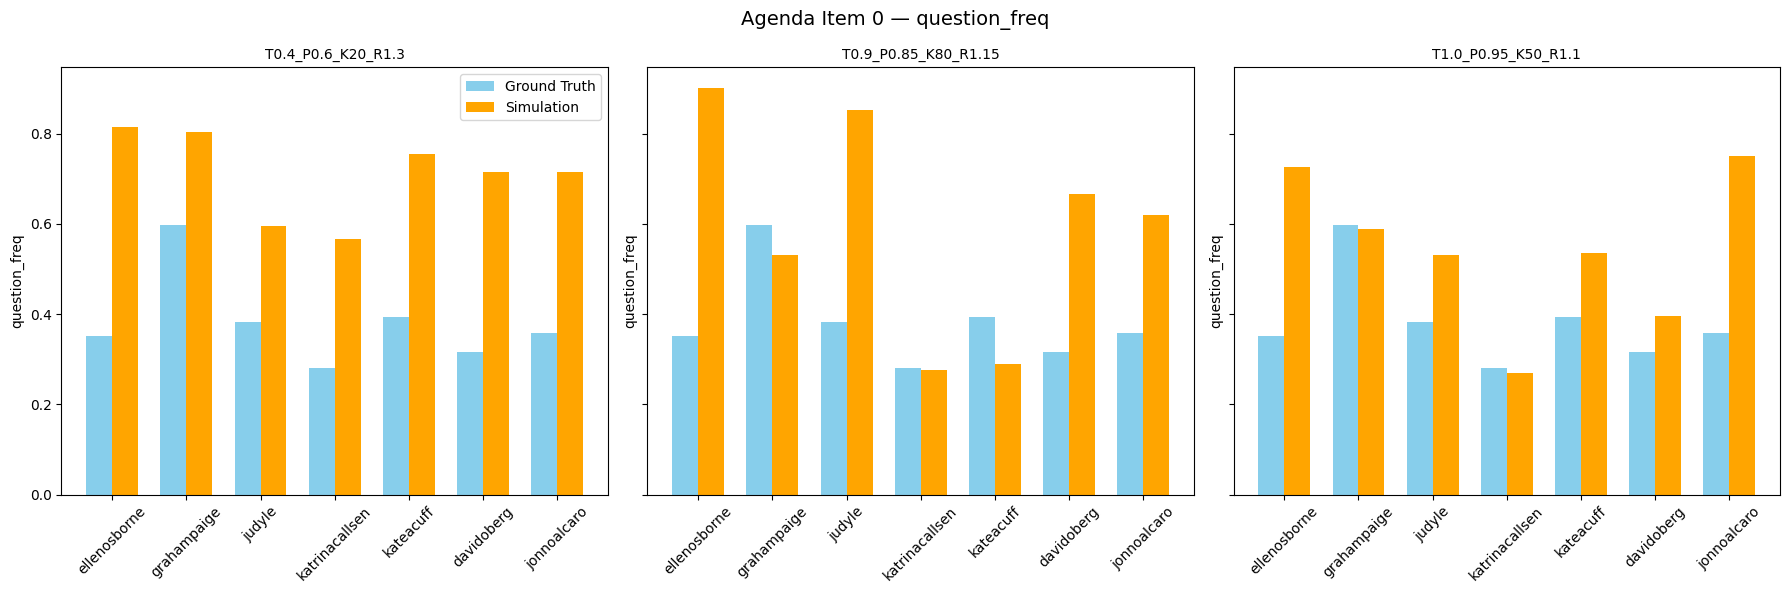

In [132]:
got_profiles = pd.DataFrame(micro_profiles)
feature = "question_freq"

for agenda_item in set(k[0] for k in messages_dict.keys()):
    # get all param sets for this agenda item
    param_sets = [k[1] for k in messages_dict.keys() if k[0] == agenda_item]

    fig, axes = plt.subplots(1, len(param_sets), figsize=(6 * len(param_sets), 6), sharey=True)
    if len(param_sets) == 1:
        axes = [axes]  # ensure iterable if only one subplot

    for ax, param_set in zip(axes, param_sets):
        messages = messages_dict[(agenda_item, param_set)]
        profiles = speaker_micro_profiles(messages)
        simulation_profiles = pd.DataFrame(profiles)

        plot_feature_comparison(got_profiles, simulation_profiles, feature, ax, param_set)

    fig.suptitle(f"Agenda Item {agenda_item} — {feature}", fontsize=14)
    axes[0].legend()
    plt.tight_layout()
    plt.savefig(f'figures/{agenda_item}_{feature}.png')
